# Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import sys

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, LeaveOneOut, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score

from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import math
import sklearn
import os
import statsmodels.api as sm

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Layer,Dropout,Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import keras.backend as K 

import mat73
import time
import datetime

from tensorflow.keras.models import load_model
import joblib


import warnings
warnings.filterwarnings('ignore')

# Definir semilla
np.random.seed(42)
# Definir la fuente global
plt.rcParams['font.family'] = 'Times New Roman'
# Definir el tamaño de fuente global
plt.rc('font', size=12)

# Functions

In [2]:
# ------------------ Create a NN -------------------------------------------
def build_model(input_dim, output_dim, num_layers, neurons_per_layer, lr, dropout_level, loss_function):
    model = Sequential()

    # Add the input layer
    model.add(Dense(neurons_per_layer, input_dim=input_dim, activation='relu'))
    model.add(Dropout(dropout_level))

    # Add the hidden layers
    for i in range(num_layers - 1):
        model.add(Dense(neurons_per_layer, activation='relu'))
        model.add(Dropout(dropout_level))

    # Add the output layer (sin activación para tareas de regresión)
    model.add(Dense(output_dim))  # Output layer sin activación

    # Compile the model
    model.compile(loss=loss_function, optimizer=Adam(learning_rate=lr))

    return model

# Load dataset

In [5]:
data_feature = 'data/dataset_BCM.csv'

df = pd.read_csv(data_feature)
df= df.dropna()

variables = ['a_CT', 'a_TA', 'Ps']
covar = ['F0', 'SPL']
X2 = df[variables]
y2 = df[covar]
df

,a_CT,a_TA,Ps,F0,SPL
0,0.00,0.0,10.0,69.348128,21.127648
1,0.01,0.0,10.0,69.323103,20.784849
2,0.02,0.0,10.0,69.444444,20.522988
3,0.03,0.0,10.0,69.722678,20.376026
4,0.04,0.0,10.0,70.126227,20.242083
...,...,...,...,...,...
418236,0.96,1.0,2010.0,248.756219,79.755342
418237,0.97,1.0,2010.0,252.451848,79.671791
418238,0.98,1.0,2010.0,256.410256,79.592400
418239,0.99,1.0,2010.0,260.419514,79.498409


In [6]:
## scaler  dataset
x_scaler = MinMaxScaler()
X = x_scaler.fit_transform(X2)

# Separating the independent variables from dependent variables
X2_train, X2_test, y2_train, y2_test=train_test_split(np.array(X),np.array(y2),test_size= 0.2)

print("Numbers of training samples: " +str(len(X2_train)))
print("Numbers of test samples: "+str(len(X2_test)))

X_train = X2_train.reshape(X2_train.shape[0], X2_train.shape[1])
X_test = X2_test.reshape(X2_test.shape[0], X2_test.shape[1])
y_test = y2_test.reshape(y2_test.shape[0],y2_test.shape[1])
y_train = y2_train.reshape(y2_train.shape[0],y2_test.shape[1])

Numbers of training samples: 331572
Numbers of test samples: 82893


# Training optimal regressors

## Neural network

In [11]:
num_layers = 3
neurons_per_layer = 128
lr = 0.001
dropout = 0.0
loss_f = 'mse'
batch = 256
EPOCH = 20
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

modelNN = build_model(X_train.shape[1], y_train.shape[1], num_layers, neurons_per_layer, lr, dropout, loss_f)
history = modelNN.fit(X_train, y_train, batch_size=batch, epochs=EPOCH, 
                    validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)

Epoch 1/20
1296/1296 [==============================] - 5s 4ms/step - loss: 2011.2234 - val_loss: 63.0547
Epoch 2/20
1296/1296 [==============================] - 5s 4ms/step - loss: 45.0665 - val_loss: 38.0840
Epoch 3/20
1296/1296 [==============================] - 5s 4ms/step - loss: 34.9600 - val_loss: 30.1124
Epoch 4/20
1296/1296 [==============================] - 5s 4ms/step - loss: 15.0470 - val_loss: 7.8694
Epoch 5/20
1296/1296 [==============================] - 5s 4ms/step - loss: 5.1710 - val_loss: 4.3571
Epoch 6/20
1296/1296 [==============================] - 5s 4ms/step - loss: 3.9400 - val_loss: 3.3740
Epoch 7/20
1296/1296 [==============================] - 5s 4ms/step - loss: 3.3232 - val_loss: 3.0107
Epoch 8/20
1296/1296 [==============================] - 5s 4ms/step - loss: 3.0087 - val_loss: 2.7058
Epoch 9/20
1296/1296 [==============================] - 5s 4ms/step - loss: 2.6457 - val_loss: 2.6299
Epoch 10/20
1296/1296 [==============================] - 5s 4ms/step - lo

In [12]:
y_pred = modelNN.predict(X_test)

results = {'F0': [], 'SPL': []}
for i in range(len(list(results.keys()))):
  results[list(results.keys())[i]] = [mean_absolute_error(y_true=np.array(y_test)[:,(i)],y_pred=y_pred[:,(i)]), mean_squared_error(y_true=np.array(y_test)[:,i],y_pred=y_pred[:,i]), mean_squared_error(y_true=np.array(y_test)[:,i],y_pred=y_pred[:,i],squared=False), r2_score(np.array(y_test)[:,i], y_pred[:,i])]
pd.DataFrame.from_dict(results, orient='index', columns=['MAE','MSE', 'RMSE', 'R2'])

2591/2591 [==============================] - 3s 1ms/step


,MAE,MSE,RMSE,R2
F0,0.773864,3.370438,1.835875,0.999673
SPL,0.310156,0.198838,0.445913,0.999025


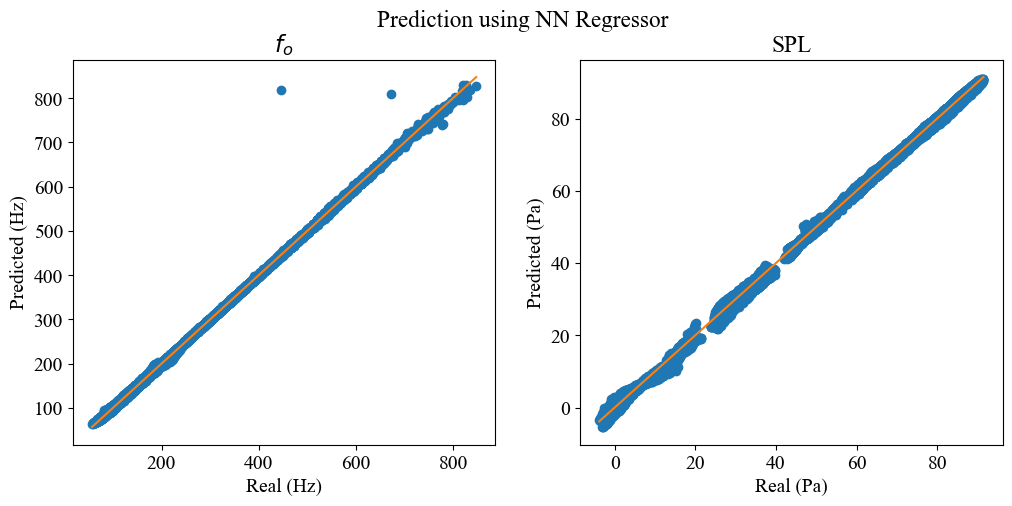

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Prediction using NN Regressor')
ax1.plot(np.array(y_test)[:,0], y_pred[:,0], 'o')
lin = [min(np.array(y_test)[:,0]), max(np.array(y_test)[:,0])]
ax1.plot(lin,lin)
ax1.set_title('$f_o$')
ax1.set_ylabel('Predicted (Hz)')
ax1.set_xlabel('Real (Hz)')
ax2.plot(np.array(y_test)[:,1], y_pred[:,1], 'o')
lin = [min(np.array(y_test)[:,1]), max(np.array(y_test)[:,1])]
ax2.plot(lin,lin)
ax2.set_ylabel('Predicted (Pa)')
ax2.set_xlabel('Real (Pa)')
ax2.set_title('SPL')
plt.show()

## Polinomial regressor

In [5]:
degree = 12

poly = PolynomialFeatures(degree=degree, include_bias=False)
modelPR = MultiOutputRegressor(estimator=LinearRegression())
modelPR.fit(poly.fit_transform(X_train), y_train)

MultiOutputRegressor(estimator=LinearRegression())

In [6]:
y_pred = modelPR.predict(poly.fit_transform(X_test))

results = {'F0': [], 'SPL': []}
for i in range(len(list(results.keys()))):
  results[list(results.keys())[i]] = [mean_absolute_error(y_true=np.array(y_test)[:,(i)],y_pred=y_pred[:,(i)]), mean_squared_error(y_true=np.array(y_test)[:,i],y_pred=y_pred[:,i]), mean_squared_error(y_true=np.array(y_test)[:,i],y_pred=y_pred[:,i],squared=False), r2_score(np.array(y_test)[:,i], y_pred[:,i])]
pd.DataFrame.from_dict(results, orient='index', columns=['MAE','MSE', 'RMSE', 'R2'])

,MAE,MSE,RMSE,R2
F0,0.523040,2.311916,1.520499,0.999776
SPL,0.182351,0.102258,0.319778,0.999499


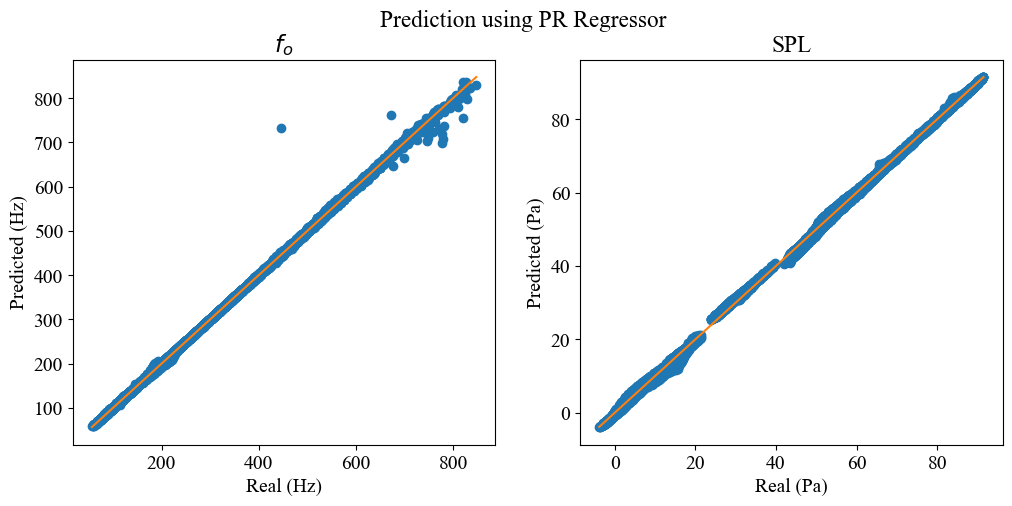

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Prediction using PR Regressor')
ax1.plot(np.array(y_test)[:,0], y_pred[:,0], 'o')
lin = [min(np.array(y_test)[:,0]), max(np.array(y_test)[:,0])]
ax1.plot(lin,lin)
ax1.set_title('$f_o$')
ax1.set_ylabel('Predicted (Hz)')
ax1.set_xlabel('Real (Hz)')
ax2.plot(np.array(y_test)[:,1], y_pred[:,1], 'o')
lin = [min(np.array(y_test)[:,1]), max(np.array(y_test)[:,1])]
ax2.plot(lin,lin)
ax2.set_ylabel('Predicted (Pa)')
ax2.set_xlabel('Real (Pa)')
ax2.set_title('SPL')
plt.show()

## Random Forest

In [8]:
depth = 40

modelRF = MultiOutputRegressor(RandomForestRegressor(max_depth=depth, random_state=0))
modelRF.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=40,
                                                     random_state=0))

In [9]:
y_pred = modelRF.predict(X_test)

results = {'F0': [], 'SPL': []}
for i in range(len(list(results.keys()))):
  results[list(results.keys())[i]] = [mean_absolute_error(y_true=np.array(y_test)[:,(i)],y_pred=y_pred[:,(i)]), mean_squared_error(y_true=np.array(y_test)[:,i],y_pred=y_pred[:,i]), mean_squared_error(y_true=np.array(y_test)[:,i],y_pred=y_pred[:,i],squared=False), r2_score(np.array(y_test)[:,i], y_pred[:,i])]
pd.DataFrame.from_dict(results, orient='index', columns=['MAE','MSE', 'RMSE', 'R2'])

,MAE,MSE,RMSE,R2
F0,0.210437,0.285088,0.533937,0.999972
SPL,0.024079,0.001719,0.041458,0.999992


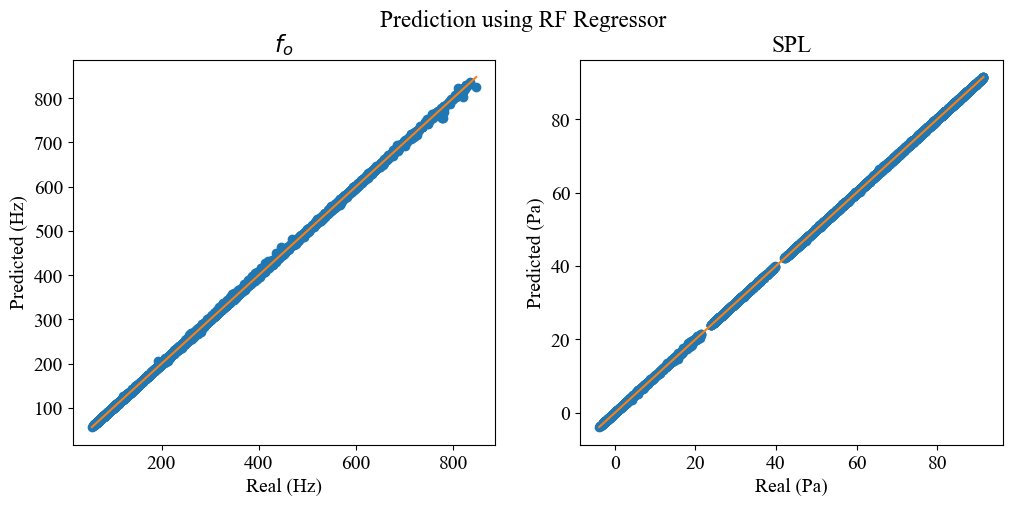

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Prediction using RF Regressor')
ax1.plot(np.array(y_test)[:,0], y_pred[:,0], 'o')
lin = [min(np.array(y_test)[:,0]), max(np.array(y_test)[:,0])]
ax1.plot(lin,lin)
ax1.set_title('$f_o$')
ax1.set_ylabel('Predicted (Hz)')
ax1.set_xlabel('Real (Hz)')
ax2.plot(np.array(y_test)[:,1], y_pred[:,1], 'o')
lin = [min(np.array(y_test)[:,1]), max(np.array(y_test)[:,1])]
ax2.plot(lin,lin)
ax2.set_ylabel('Predicted (Pa)')
ax2.set_xlabel('Real (Pa)')
ax2.set_title('SPL')
plt.show()

# Time comparison

In [14]:
# time measure parameters
sample_sizes = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000]  # Tamaños de muestra
n_repeats = 8  # 
# Create empty DataFrame
execution_times = {
    'Sample Size': [],
    'Random Forest Time': [],
    'NN Time': [],
    'Polynomial Regressor Time': []
}

In [15]:
# Loop over different sample sizes to measure prediction time
for n_samples in sample_sizes:
    rf_times, nn_times, poly_times = [], [], []

    for _ in range(n_repeats):
        # Generate test data with the current sample size
        X_test = np.random.rand(n_samples, 3)  # 3 input features
        Y_test = np.random.rand(n_samples, 2)  # 2 output targets (e.g., F0 and SPL)

        
        # Measure prediction time for Random Forest
        start_time = time.time()
        modelRF.predict(X_test)
        rf_times.append(time.time() - start_time)

        # Measure prediction time for Neural Network
        start_time = time.time()
        modelNN.predict(X_test)
        nn_times.append(time.time() - start_time)

        # Measure prediction time for Polynomial Regressor
        start_time = time.time()
        X_poly_test = poly.transform(X_test)
        modelPR.predict(X_poly_test)
        poly_times.append(time.time() - start_time)

    # Store mean execution times
    execution_times['Sample Size'].append(n_samples)
    execution_times['Random Forest Time'].append(np.mean(rf_times))
    execution_times['NN Time'].append(np.mean(nn_times))
    execution_times['Polynomial Regressor Time'].append(np.mean(poly_times))

    print(f"Sample Size: {n_samples} - RF Mean Time: {np.mean(rf_times):.4f}s, NN Mean Time: {np.mean(nn_times):.4f}s, Poly Mean Time: {np.mean(poly_times):.4f}s")

# Convert results into a DataFrame
times_df = pd.DataFrame(execution_times)

# Save results to a CSV file for further analysis
times_df.to_csv('execution_times_comparison.csv', index=False)

1/1 [==============================] - 0s 18ms/step
Sample Size: 1 - RF Mean Time: 0.0087s, NN Mean Time: 0.0461s, Poly Mean Time: 0.0007s
1/1 [==============================] - 0s 17ms/step
Sample Size: 2 - RF Mean Time: 0.0097s, NN Mean Time: 0.0468s, Poly Mean Time: 0.0009s
1/1 [==============================] - 0s 18ms/step
Sample Size: 5 - RF Mean Time: 0.0093s, NN Mean Time: 0.0504s, Poly Mean Time: 0.0007s
1/1 [==============================] - 0s 17ms/step
Sample Size: 10 - RF Mean Time: 0.0101s, NN Mean Time: 0.0455s, Poly Mean Time: 0.0008s
1/1 [==============================] - 0s 17ms/step
Sample Size: 20 - RF Mean Time: 0.0126s, NN Mean Time: 0.0448s, Poly Mean Time: 0.0008s
2/2 [==============================] - 0s 2ms/step
Sample Size: 50 - RF Mean Time: 0.0191s, NN Mean Time: 0.0534s, Poly Mean Time: 0.0009s
4/4 [==============================] - 0s 2ms/step
Sample Size: 100 - RF Mean Time: 0.0272s, NN Mean Time: 0.0578s, Poly Mean Time: 0.0013s
7/7 [===================

6250/6250 [==============================] - 8s 1ms/step
Sample Size: 200000 - RF Mean Time: 15.0046s, NN Mean Time: 9.6203s, Poly Mean Time: 0.8823s
15625/15625 [==============================] - 18s 1ms/step
Sample Size: 500000 - RF Mean Time: 37.0522s, NN Mean Time: 24.2171s, Poly Mean Time: 2.0588s
31250/31250 [==============================] - 31s 999us/step
Sample Size: 1000000 - RF Mean Time: 67.6081s, NN Mean Time: 44.0811s, Poly Mean Time: 3.9582s


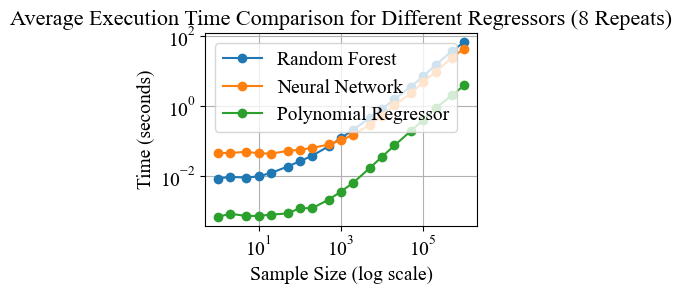

In [16]:
# Plot size
plt.figure(figsize=(10, 6))

# Plot each regressor
plt.plot(times_df['Sample Size'], times_df['Random Forest Time'], label='Random Forest', marker='o')
plt.plot(times_df['Sample Size'], times_df['NN Time'], label='Neural Network', marker='o')
plt.plot(times_df['Sample Size'], times_df['Polynomial Regressor Time'], label='Polynomial Regressor', marker='o')

plt.xscale('log')
plt.yscale('log')

# axis and title
plt.xlabel('Sample Size (log scale)', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
#plt.title('Average Execution Time Comparison for Different Regressors (8 Repeats)', fontsize=12)

plt.legend()
plt.grid(True)

# Show the plot
output_filename = 'Figs/Times_regressor_log.svg'
plt.savefig(output_filename, format='svg')
plt.show()

# Save regressors

In [14]:
# Save the NN model
modelNN.save('models/NN_BCM.h5')

# Save the RF and PR models
joblib.dump(modelRF, 'models/RF_BCM.pkl', compress=5)  
joblib.dump(modelPR, 'models/PR_BCM.pkl')  

# save the normalization object
joblib.dump(x_scaler, 'models/x_scaler_BCM.pkl')

['models/x_scaler_BCM.pkl']

# Load regressors

In [3]:
# load the models
modelNN = load_model('models/NN_BCM.h5')

modelRF = joblib.load('models/RF_BCM.pkl')
modelPR = joblib.load('models/PR_BCM.pkl')

x_scaler = joblib.load('models/x_scaler_BCM.pkl')

degree = 12
poly = PolynomialFeatures(degree=degree, include_bias=False)

# Heatmap comparison

In [8]:
# dataset2
df2 = create_new_dataset(data_dict,40)
df2= df2.dropna()

In [11]:
df2 = df2[df2['Ps']==1010]
variables = ['a_CT', 'a_TA', 'Ps']
covar = ['F0', 'SPL']

X = df2[variables]
X_norm = x_scaler.transform(X)

y = np.array(df2[covar])

In [14]:
# Prepare input data for prediction
ps = 0.5
ct = df2['a_CT'].unique()
ta = df2['a_TA'].unique()

# Generate grid of input values
X, Y = np.meshgrid(ta, ct)

# Prepare input data for prediction
n_rows, n_cols = X.shape
input_data = np.zeros((n_rows * n_cols, 3))
input_data[:, 0] = X.flatten()
input_data[:, 1] = Y.flatten()
input_data[:, 2] = ps  # Set constant input

# Predict outputs using the Linear model
Z1_l = y[:,0].reshape((n_rows, n_cols))
Z2_l = y[:,1].reshape((n_rows, n_cols))

22/22 [==============================] - 0s 2ms/step


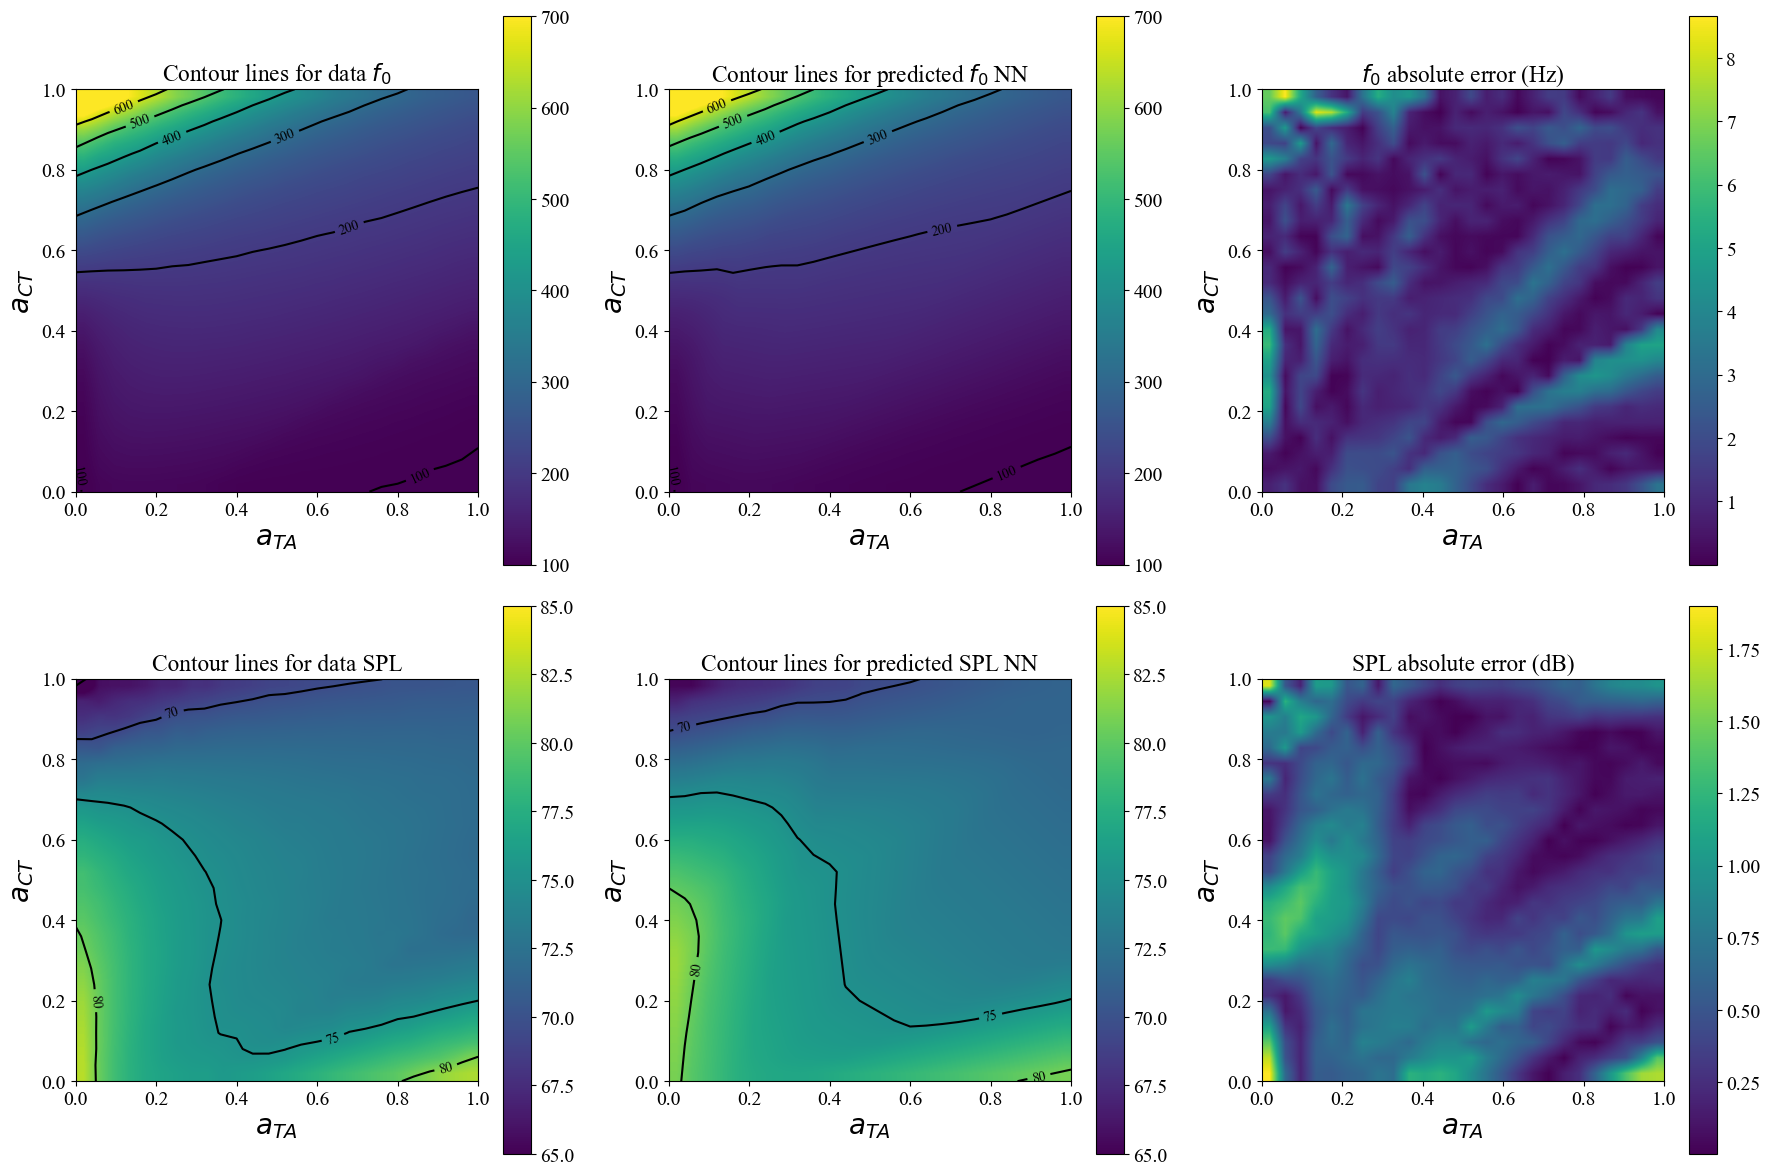

In [26]:
reg = 'NN'

# Predict outputs using the random forest model
predictions = modelNN.predict(input_data)
Z1 = predictions[:, 0].reshape((n_rows, n_cols))
Z2 = predictions[:, 1].reshape((n_rows, n_cols))

# Definir niveles específicos para los contornos
levels_f0 = [100, 200, 300, 400,500,600]  # Para F0
levels_spl = np.arange(65, 90, 5)  # Para SPL (70, 75, 80,..., 100)

# Graficar los resultados
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Gráfico 1: Contour lines for data F0
im1 = axs[0, 0].imshow(Z1_l.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=100, vmax=700)
CS1 = axs[0, 0].contour(Y, X, Z1_l, levels=levels_f0, colors='k')
axs[0, 0].clabel(CS1, inline=True, fontsize=10)
axs[0, 0].set_title('Contour lines for data $f_0$')
axs[0, 0].set_xlabel('$a_{TA}$', fontsize=20)
axs[0, 0].set_ylabel('$a_{CT}$', fontsize=20)
plt.colorbar(im1, ax=axs[0, 0])  # Barra de color para subplot 1

# Gráfico 2: Contour lines for predicted F0 (NN)
im2 = axs[0, 1].imshow(Z1.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=100, vmax=700)
CS2 = axs[0, 1].contour(Y, X, Z1, levels=levels_f0, colors='k')
axs[0, 1].clabel(CS2, inline=True, fontsize=10)
axs[0, 1].set_title('Contour lines for predicted $f_0$ '+reg)
axs[0, 1].set_xlabel('$a_{TA}$', fontsize=20)
axs[0, 1].set_ylabel('$a_{CT}$', fontsize=20)
plt.colorbar(im2, ax=axs[0, 1])  # Barra de color para subplot 2

# Gráfico 3: Error absoluto entre valores de F0
error_f0 = np.abs(Z1_l.T - Z1.T)  # Error absoluto
im3 = axs[0, 2].imshow(error_f0, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]))
axs[0, 2].set_title('$f_0$ absolute error (Hz)')
axs[0, 2].set_xlabel('$a_{TA}$', fontsize=20)
axs[0, 2].set_ylabel('$a_{CT}$', fontsize=20)
plt.colorbar(im3, ax=axs[0, 2])  # Barra de color para error F0

# Gráfico 4: Contour lines for data SPL
im4 = axs[1, 0].imshow(Z2_l.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=65, vmax=85)
CS4 = axs[1, 0].contour(Y, X, Z2_l, levels=levels_spl, colors='k')
axs[1, 0].clabel(CS4, inline=True, fontsize=10)
axs[1, 0].set_title('Contour lines for data SPL')
axs[1, 0].set_xlabel('$a_{TA}$', fontsize=20)
axs[1, 0].set_ylabel('$a_{CT}$', fontsize=20)
plt.colorbar(im4, ax=axs[1, 0])  # Barra de color para subplot 3

# Gráfico 5: Contour lines for predicted SPL (NN)
im5 = axs[1, 1].imshow(Z2.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=65, vmax=85)
CS5 = axs[1, 1].contour(Y, X, Z2, levels=levels_spl, colors='k')
axs[1, 1].clabel(CS5, inline=True, fontsize=10)
axs[1, 1].set_title('Contour lines for predicted SPL '+reg)
axs[1, 1].set_xlabel('$a_{TA}$', fontsize=20)
axs[1, 1].set_ylabel('$a_{CT}$', fontsize=20)
plt.colorbar(im5, ax=axs[1, 1])  # Barra de color para subplot 4

# Gráfico 6: Error absoluto entre valores de SPL
error_spl = np.abs(Z2_l.T - Z2.T)  # Error absoluto
im6 = axs[1, 2].imshow(error_spl, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]))
axs[1, 2].set_title('SPL absolute error (dB)')
axs[1, 2].set_xlabel('$a_{TA}$', fontsize=20)
axs[1, 2].set_ylabel('$a_{CT}$', fontsize=20)
plt.colorbar(im6, ax=axs[1, 2])  # Barra de color para error SPL

# Ajustar espacios entre subplots
plt.tight_layout()    
    
output_filename = 'Figs/heatmap_BCM_'+reg+'.svg'
plt.savefig(output_filename, format='svg')
plt.show()

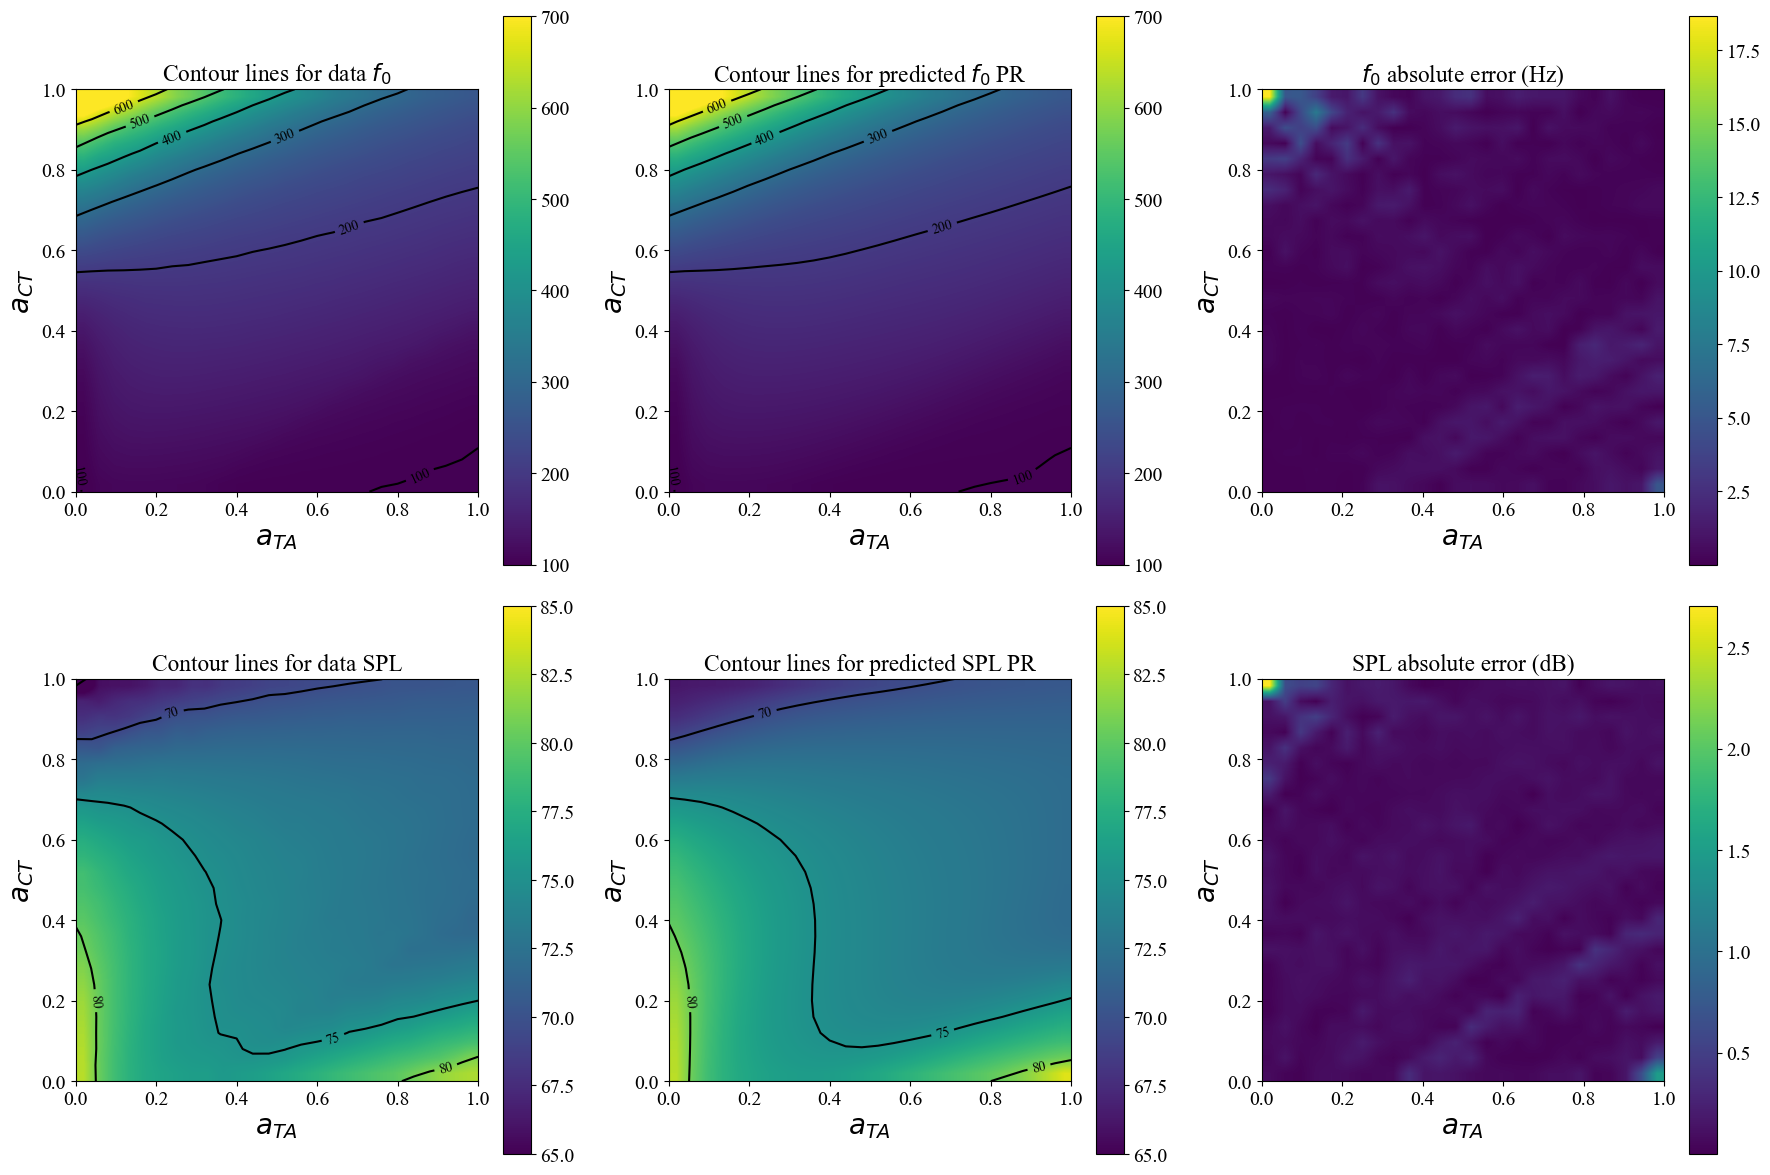

In [27]:
reg = 'PR'

# Predict outputs using the polynomial model
predictions = modelPR.predict(poly.fit_transform(input_data))
Z1 = predictions[:, 0].reshape((n_rows, n_cols))
Z2 = predictions[:, 1].reshape((n_rows, n_cols))

# Definir niveles específicos para los contornos
levels_f0 = [100, 200, 300, 400,500,600]  # Para F0
levels_spl = np.arange(65, 90, 5)  # Para SPL (70, 75, 80,..., 100)

# Graficar los resultados
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Gráfico 1: Contour lines for data F0
im1 = axs[0, 0].imshow(Z1_l.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=100, vmax=700)
CS1 = axs[0, 0].contour(Y, X, Z1_l, levels=levels_f0, colors='k')
axs[0, 0].clabel(CS1, inline=True, fontsize=10)
axs[0, 0].set_title('Contour lines for data $f_0$')
axs[0, 0].set_xlabel('$a_{TA}$', fontsize=20)
axs[0, 0].set_ylabel('$a_{CT}$', fontsize=20)
plt.colorbar(im1, ax=axs[0, 0])  # Barra de color para subplot 1

# Gráfico 2: Contour lines for predicted F0 (NN)
im2 = axs[0, 1].imshow(Z1.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=100, vmax=700)
CS2 = axs[0, 1].contour(Y, X, Z1, levels=levels_f0, colors='k')
axs[0, 1].clabel(CS2, inline=True, fontsize=10)
axs[0, 1].set_title('Contour lines for predicted $f_0$ '+reg)
axs[0, 1].set_xlabel('$a_{TA}$', fontsize=20)
axs[0, 1].set_ylabel('$a_{CT}$', fontsize=20)
plt.colorbar(im2, ax=axs[0, 1])  # Barra de color para subplot 2

# Gráfico 3: Error absoluto entre valores de F0
error_f0 = np.abs(Z1_l.T - Z1.T)  # Error absoluto
im3 = axs[0, 2].imshow(error_f0, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]))
axs[0, 2].set_title('$f_0$ absolute error (Hz)')
axs[0, 2].set_xlabel('$a_{TA}$', fontsize=20)
axs[0, 2].set_ylabel('$a_{CT}$', fontsize=20)
plt.colorbar(im3, ax=axs[0, 2])  # Barra de color para error F0

# Gráfico 4: Contour lines for data SPL
im4 = axs[1, 0].imshow(Z2_l.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=65, vmax=85)
CS4 = axs[1, 0].contour(Y, X, Z2_l, levels=levels_spl, colors='k')
axs[1, 0].clabel(CS4, inline=True, fontsize=10)
axs[1, 0].set_title('Contour lines for data SPL')
axs[1, 0].set_xlabel('$a_{TA}$', fontsize=20)
axs[1, 0].set_ylabel('$a_{CT}$', fontsize=20)
plt.colorbar(im4, ax=axs[1, 0])  # Barra de color para subplot 3

# Gráfico 5: Contour lines for predicted SPL (NN)
im5 = axs[1, 1].imshow(Z2.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=65, vmax=85)
CS5 = axs[1, 1].contour(Y, X, Z2, levels=levels_spl, colors='k')
axs[1, 1].clabel(CS5, inline=True, fontsize=10)
axs[1, 1].set_title('Contour lines for predicted SPL '+reg)
axs[1, 1].set_xlabel('$a_{TA}$', fontsize=20)
axs[1, 1].set_ylabel('$a_{CT}$', fontsize=20)
plt.colorbar(im5, ax=axs[1, 1])  # Barra de color para subplot 4

# Gráfico 6: Error absoluto entre valores de SPL
error_spl = np.abs(Z2_l.T - Z2.T)  # Error absoluto
im6 = axs[1, 2].imshow(error_spl, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]))
axs[1, 2].set_title('SPL absolute error (dB)')
axs[1, 2].set_xlabel('$a_{TA}$', fontsize=20)
axs[1, 2].set_ylabel('$a_{CT}$', fontsize=20)
plt.colorbar(im6, ax=axs[1, 2])  # Barra de color para error SPL

# Ajustar espacios entre subplots
plt.tight_layout()
    
output_filename = 'Figs/heatmap_BCM_'+reg+'.svg'
plt.savefig(output_filename, format='svg')
plt.show()

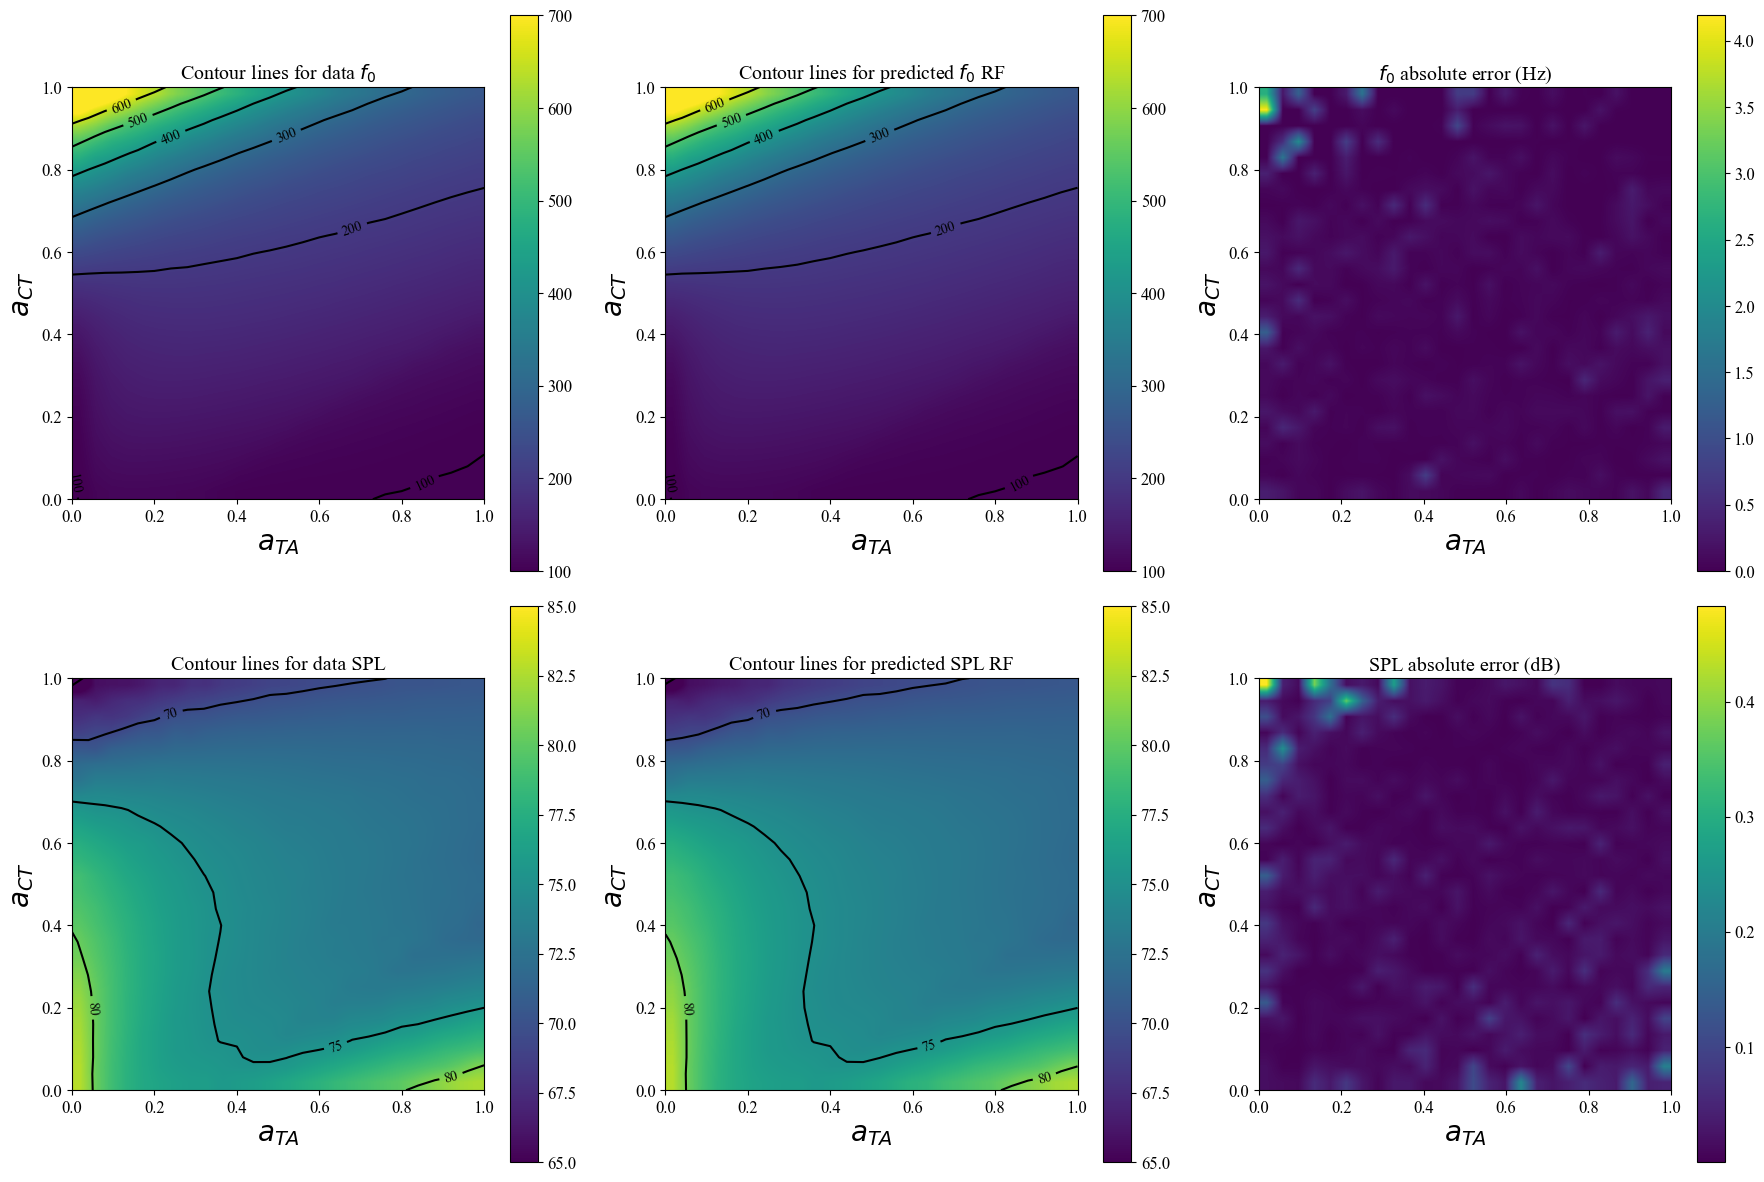

In [18]:
reg = 'RF'
# Predict outputs using the random forest model
predictions = modelRF.predict(input_data)
Z1 = predictions[:, 0].reshape((n_rows, n_cols))
Z2 = predictions[:, 1].reshape((n_rows, n_cols))

# Definir niveles específicos para los contornos
levels_f0 = [100, 200, 300, 400,500,600]  # Para F0
levels_spl = np.arange(65, 90, 5)  # Para SPL (70, 75, 80,..., 100)

# Graficar los resultados
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Gráfico 1: Contour lines for data F0
im1 = axs[0, 0].imshow(Z1_l.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=100, vmax=700)
CS1 = axs[0, 0].contour(Y, X, Z1_l, levels=levels_f0, colors='k')
axs[0, 0].clabel(CS1, inline=True, fontsize=10)
axs[0, 0].set_title('Contour lines for data $f_0$')
axs[0, 0].set_xlabel('$a_{TA}$', fontsize=20)
axs[0, 0].set_ylabel('$a_{CT}$', fontsize=20)
plt.colorbar(im1, ax=axs[0, 0])  # Barra de color para subplot 1

# Gráfico 2: Contour lines for predicted F0 (NN)
im2 = axs[0, 1].imshow(Z1.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=100, vmax=700)
CS2 = axs[0, 1].contour(Y, X, Z1, levels=levels_f0, colors='k')
axs[0, 1].clabel(CS2, inline=True, fontsize=10)
axs[0, 1].set_title('Contour lines for predicted $f_0$ '+reg)
axs[0, 1].set_xlabel('$a_{TA}$', fontsize=20)
axs[0, 1].set_ylabel('$a_{CT}$', fontsize=20)
plt.colorbar(im2, ax=axs[0, 1])  # Barra de color para subplot 2

# Gráfico 3: Error absoluto entre valores de F0
error_f0 = np.abs(Z1_l.T - Z1.T)  # Error absoluto
im3 = axs[0, 2].imshow(error_f0, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]))
axs[0, 2].set_title('$f_0$ absolute error (Hz)')
axs[0, 2].set_xlabel('$a_{TA}$', fontsize=20)
axs[0, 2].set_ylabel('$a_{CT}$', fontsize=20)
plt.colorbar(im3, ax=axs[0, 2])  # Barra de color para error F0

# Gráfico 4: Contour lines for data SPL
im4 = axs[1, 0].imshow(Z2_l.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=65, vmax=85)
CS4 = axs[1, 0].contour(Y, X, Z2_l, levels=levels_spl, colors='k')
axs[1, 0].clabel(CS4, inline=True, fontsize=10)
axs[1, 0].set_title('Contour lines for data SPL')
axs[1, 0].set_xlabel('$a_{TA}$', fontsize=20)
axs[1, 0].set_ylabel('$a_{CT}$', fontsize=20)
plt.colorbar(im4, ax=axs[1, 0])  # Barra de color para subplot 3

# Gráfico 5: Contour lines for predicted SPL (NN)
im5 = axs[1, 1].imshow(Z2.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=65, vmax=85)
CS5 = axs[1, 1].contour(Y, X, Z2, levels=levels_spl, colors='k')
axs[1, 1].clabel(CS5, inline=True, fontsize=10)
axs[1, 1].set_title('Contour lines for predicted SPL '+reg)
axs[1, 1].set_xlabel('$a_{TA}$', fontsize=20)
axs[1, 1].set_ylabel('$a_{CT}$', fontsize=20)
plt.colorbar(im5, ax=axs[1, 1])  # Barra de color para subplot 4

# Gráfico 6: Error absoluto entre valores de SPL
error_spl = np.abs(Z2_l.T - Z2.T)  # Error absoluto
im6 = axs[1, 2].imshow(error_spl, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]))
axs[1, 2].set_title('SPL absolute error (dB)')
axs[1, 2].set_xlabel('$a_{TA}$', fontsize=20)
axs[1, 2].set_ylabel('$a_{CT}$', fontsize=20)
plt.colorbar(im6, ax=axs[1, 2])  # Barra de color para error SPL

# Ajustar espacios entre subplots
plt.tight_layout()
    
output_filename = 'Figs/heatmap_BCM_'+reg+'.svg'
plt.savefig(output_filename, format='svg')
plt.show()

22/22 [==============================] - 0s 3ms/step


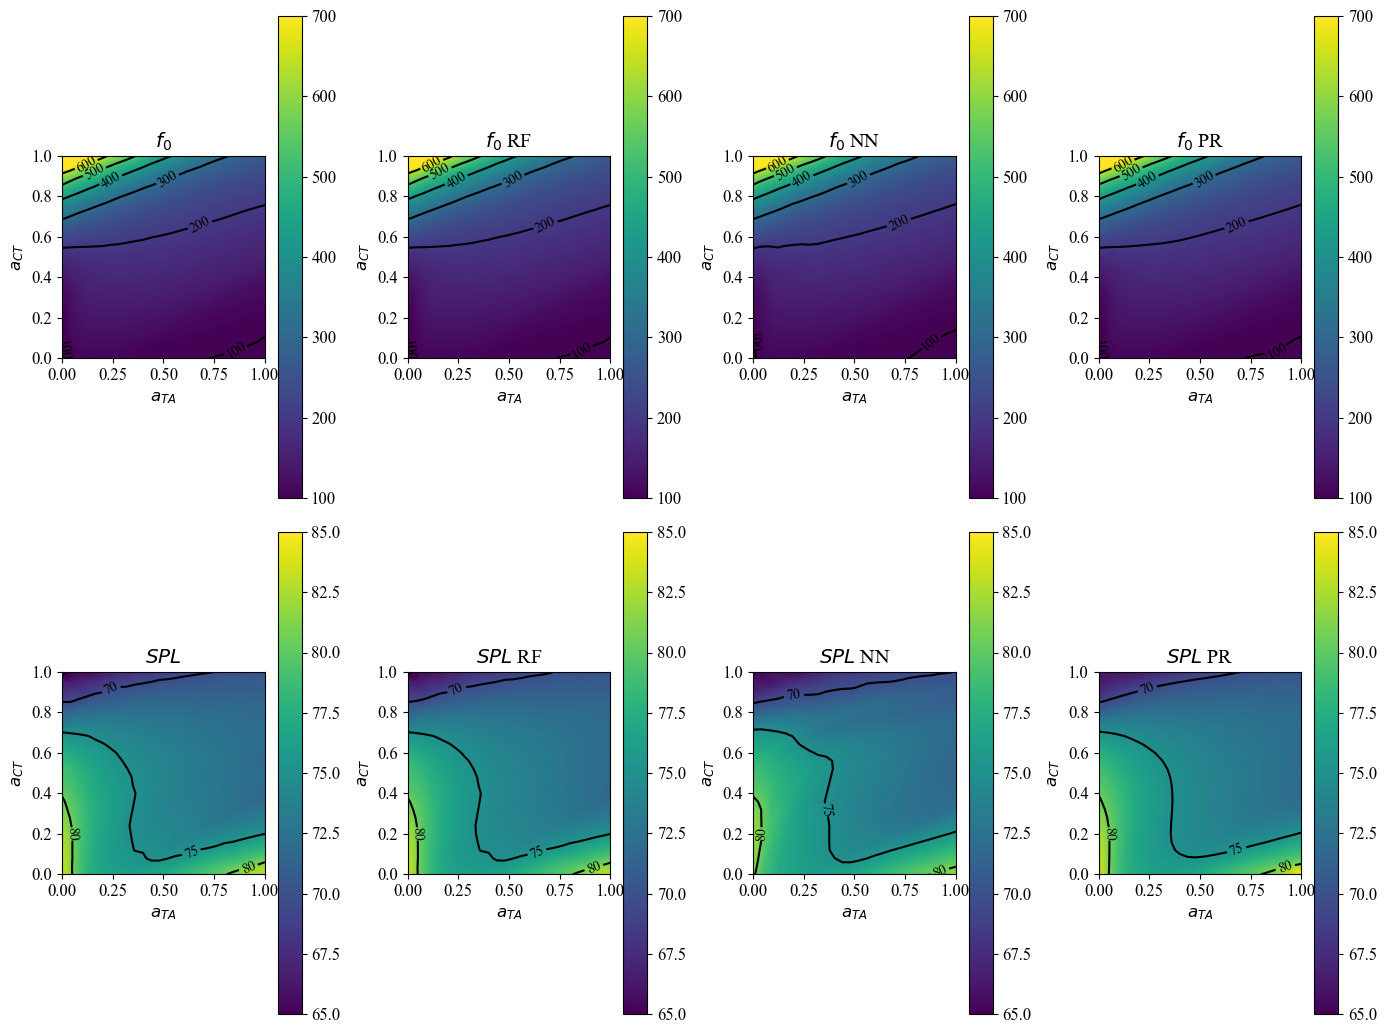

In [21]:
# Definir niveles específicos para los contornos
levels_f0 = [100, 200, 300, 400,500,600]  # Para F0
levels_spl = np.arange(65, 90, 5)  # Para SPL (70, 75, 80,..., 100)

# Graficar los resultados
fig, axs = plt.subplots(2, 4, figsize=(14, 10.5))

# Gráficos Dataset
# fo
im1 = axs[0, 0].imshow(Z1_l.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=100, vmax=700)
CS1 = axs[0, 0].contour(Y, X, Z1_l, levels=levels_f0, colors='k')
axs[0, 0].clabel(CS1, inline=True, fontsize=10)
axs[0, 0].set_title('$f_0$')
axs[0, 0].set_xlabel('$a_{TA}$', fontsize=12)
axs[0, 0].set_ylabel('$a_{CT}$', fontsize=12)
plt.colorbar(im1, ax=axs[0, 0])  # Barra de color
# SPL
im4 = axs[1, 0].imshow(Z2_l.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=65, vmax=85)
CS4 = axs[1, 0].contour(Y, X, Z2_l, levels=levels_spl, colors='k')
axs[1, 0].clabel(CS4, inline=True, fontsize=10)
axs[1, 0].set_title('$SPL$')
axs[1, 0].set_xlabel('$a_{TA}$', fontsize=12)
axs[1, 0].set_ylabel('$a_{CT}$', fontsize=12)
plt.colorbar(im4, ax=axs[1, 0])  # Barra de color

# Gráficos RF
reg = 'RF'
# Predict outputs using the RF model
predictions = modelRF.predict(input_data)
Z1 = predictions[:, 0].reshape((n_rows, n_cols))
Z2 = predictions[:, 1].reshape((n_rows, n_cols))
# fo
im2 = axs[0, 1].imshow(Z1.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=100, vmax=700)
CS2 = axs[0, 1].contour(Y, X, Z1, levels=levels_f0, colors='k')
axs[0, 1].clabel(CS2, inline=True, fontsize=10)
axs[0, 1].set_title('$f_0$ '+reg)
axs[0, 1].set_xlabel('$a_{TA}$', fontsize=12)
axs[0, 1].set_ylabel('$a_{CT}$', fontsize=12)
plt.colorbar(im2, ax=axs[0, 1])  # Barra de color
# SPL
im5 = axs[1, 1].imshow(Z2.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=65, vmax=85)
CS5 = axs[1, 1].contour(Y, X, Z2, levels=levels_spl, colors='k')
axs[1, 1].clabel(CS5, inline=True, fontsize=10)
axs[1, 1].set_title('$SPL$ '+reg)
axs[1, 1].set_xlabel('$a_{TA}$', fontsize=12)
axs[1, 1].set_ylabel('$a_{CT}$', fontsize=12)
plt.colorbar(im5, ax=axs[1, 1])  # Barra de color

# Gráficos NN
reg = 'NN'
# Predict outputs using the NN model
predictions = modelNN.predict(input_data)
Z1 = predictions[:, 0].reshape((n_rows, n_cols))
Z2 = predictions[:, 1].reshape((n_rows, n_cols))
# fo
im2 = axs[0, 2].imshow(Z1.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=100, vmax=700)
CS2 = axs[0, 2].contour(Y, X, Z1, levels=levels_f0, colors='k')
axs[0, 2].clabel(CS2, inline=True, fontsize=10)
axs[0, 2].set_title('$f_0$ '+reg)
axs[0, 2].set_xlabel('$a_{TA}$', fontsize=12)
axs[0, 2].set_ylabel('$a_{CT}$', fontsize=12)
plt.colorbar(im2, ax=axs[0, 2])  # Barra de color
# SPL
im5 = axs[1, 2].imshow(Z2.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=65, vmax=85)
CS5 = axs[1, 2].contour(Y, X, Z2, levels=levels_spl, colors='k')
axs[1, 2].clabel(CS5, inline=True, fontsize=10)
axs[1, 2].set_title('$SPL$ '+reg)
axs[1, 2].set_xlabel('$a_{TA}$', fontsize=12)
axs[1, 2].set_ylabel('$a_{CT}$', fontsize=12)
plt.colorbar(im5, ax=axs[1, 2])  # Barra de color

# Gráficos PR
reg = 'PR'
# Predict outputs using the polynomial model
predictions = modelPR.predict(poly.fit_transform(input_data))
Z1 = predictions[:, 0].reshape((n_rows, n_cols))
Z2 = predictions[:, 1].reshape((n_rows, n_cols))
# fo
im2 = axs[0, 3].imshow(Z1.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=100, vmax=700)
CS2 = axs[0, 3].contour(Y, X, Z1, levels=levels_f0, colors='k')
axs[0, 3].clabel(CS2, inline=True, fontsize=10)
axs[0, 3].set_title('$f_0$ '+reg)
axs[0, 3].set_xlabel('$a_{TA}$', fontsize=12)
axs[0, 3].set_ylabel('$a_{CT}$', fontsize=12)
plt.colorbar(im2, ax=axs[0, 3])  # Barra de color
# SPL
im5 = axs[1, 3].imshow(Z2.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=65, vmax=85)
CS5 = axs[1, 3].contour(Y, X, Z2, levels=levels_spl, colors='k')
axs[1, 3].clabel(CS5, inline=True, fontsize=10)
axs[1, 3].set_title('$SPL$ '+reg)
axs[1, 3].set_xlabel('$a_{TA}$', fontsize=12)
axs[1, 3].set_ylabel('$a_{CT}$', fontsize=12)
plt.colorbar(im5, ax=axs[1, 3])  # Barra de color

# Ajustar espacios entre subplots
plt.tight_layout()    
    
output_filename = 'Figs/heatmap_BCM.svg'
plt.savefig(output_filename, format='svg')
plt.show()

22/22 [==============================] - 0s 2ms/step


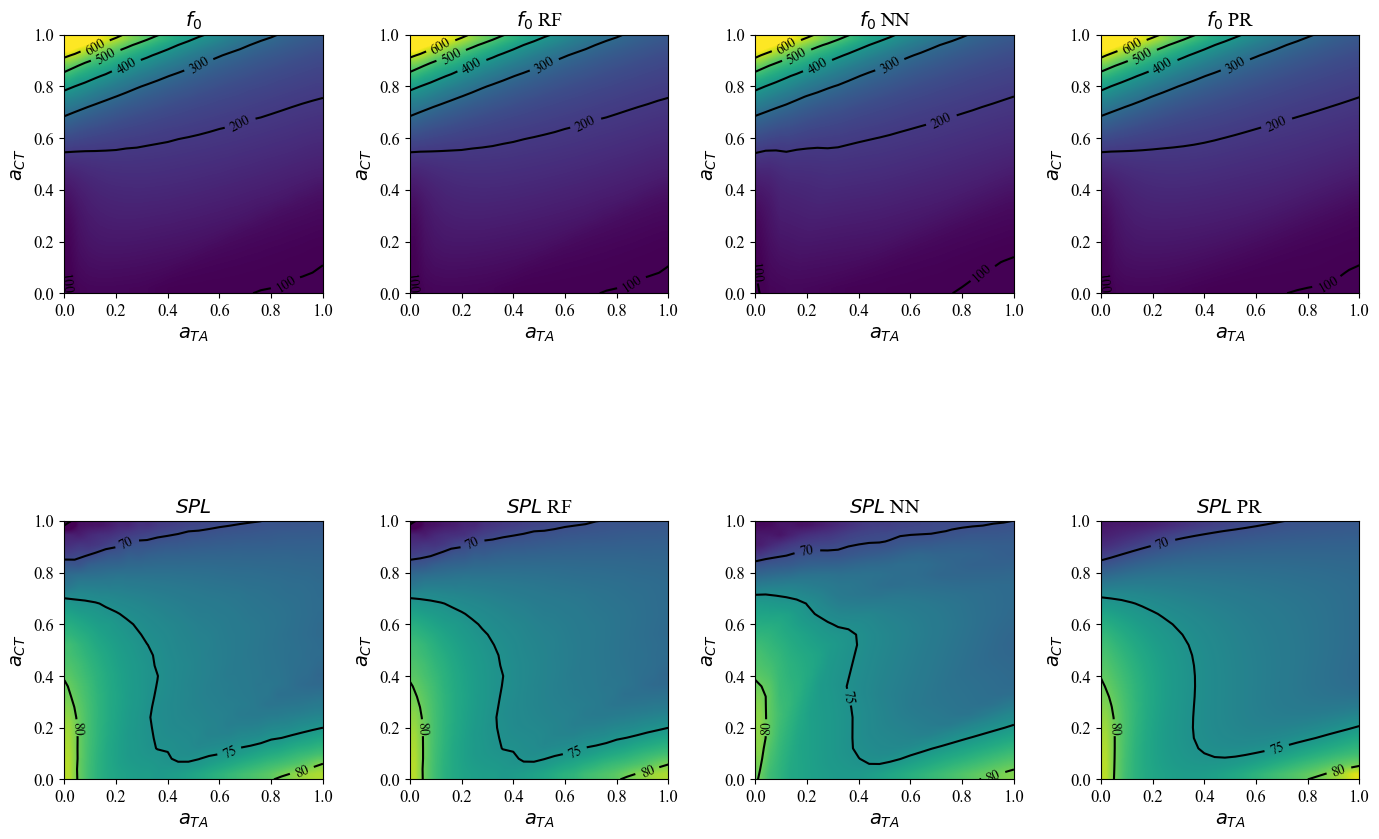

In [23]:
# Define some contours
levels_f0 = [100, 200, 300, 400,500,600] 
levels_spl = np.arange(65, 90, 5)  

fig, axs = plt.subplots(2, 4, figsize=(14, 10.5))

# Plots Dataset
# fo
im1 = axs[0, 0].imshow(Z1_l.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=100, vmax=700)
CS1 = axs[0, 0].contour(Y, X, Z1_l, levels=levels_f0, colors='k')
axs[0, 0].clabel(CS1, inline=True, fontsize=10)
axs[0, 0].set_title('$f_0$')
axs[0, 0].set_xlabel('$a_{TA}$', fontsize=14)
axs[0, 0].set_ylabel('$a_{CT}$', fontsize=14)
#plt.colorbar(im1, ax=axs[0, 0])  
# SPL
im4 = axs[1, 0].imshow(Z2_l.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=65, vmax=85)
CS4 = axs[1, 0].contour(Y, X, Z2_l, levels=levels_spl, colors='k')
axs[1, 0].clabel(CS4, inline=True, fontsize=10)
axs[1, 0].set_title('$SPL$')
axs[1, 0].set_xlabel('$a_{TA}$', fontsize=14)
axs[1, 0].set_ylabel('$a_{CT}$', fontsize=14)
#plt.colorbar(im4, ax=axs[1, 0])  

# Plots RF
reg = 'RF'
# Predict outputs using the RF model
predictions = modelRF.predict(input_data)
Z1 = predictions[:, 0].reshape((n_rows, n_cols))
Z2 = predictions[:, 1].reshape((n_rows, n_cols))
# fo
im2 = axs[0, 1].imshow(Z1.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=100, vmax=700)
CS2 = axs[0, 1].contour(Y, X, Z1, levels=levels_f0, colors='k')
axs[0, 1].clabel(CS2, inline=True, fontsize=10)
axs[0, 1].set_title('$f_0$ '+reg)
axs[0, 1].set_xlabel('$a_{TA}$', fontsize=14)
axs[0, 1].set_ylabel('$a_{CT}$', fontsize=14)
#plt.colorbar(im2, ax=axs[0, 1])  
# SPL
im5 = axs[1, 1].imshow(Z2.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=65, vmax=85)
CS5 = axs[1, 1].contour(Y, X, Z2, levels=levels_spl, colors='k')
axs[1, 1].clabel(CS5, inline=True, fontsize=10)
axs[1, 1].set_title('$SPL$ '+reg)
axs[1, 1].set_xlabel('$a_{TA}$', fontsize=14)
axs[1, 1].set_ylabel('$a_{CT}$', fontsize=14)
#plt.colorbar(im5, ax=axs[1, 1]) 

# Plots NN
reg = 'NN'
# Predict outputs using the NN model
predictions = modelNN.predict(input_data)
Z1 = predictions[:, 0].reshape((n_rows, n_cols))
Z2 = predictions[:, 1].reshape((n_rows, n_cols))
# fo
im2 = axs[0, 2].imshow(Z1.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=100, vmax=700)
CS2 = axs[0, 2].contour(Y, X, Z1, levels=levels_f0, colors='k')
axs[0, 2].clabel(CS2, inline=True, fontsize=10)
axs[0, 2].set_title('$f_0$ '+reg)
axs[0, 2].set_xlabel('$a_{TA}$', fontsize=14)
axs[0, 2].set_ylabel('$a_{CT}$', fontsize=14)
#plt.colorbar(im2, ax=axs[0, 2])  # Barra de color
# SPL
im5 = axs[1, 2].imshow(Z2.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=65, vmax=85)
CS5 = axs[1, 2].contour(Y, X, Z2, levels=levels_spl, colors='k')
axs[1, 2].clabel(CS5, inline=True, fontsize=10)
axs[1, 2].set_title('$SPL$ '+reg)
axs[1, 2].set_xlabel('$a_{TA}$', fontsize=14)
axs[1, 2].set_ylabel('$a_{CT}$', fontsize=14)
#plt.colorbar(im5, ax=axs[1, 2])  # Barra de color

# Gráficos PR
reg = 'PR'
# Predict outputs using the polynomial model
predictions = modelPR.predict(poly.fit_transform(input_data))
Z1 = predictions[:, 0].reshape((n_rows, n_cols))
Z2 = predictions[:, 1].reshape((n_rows, n_cols))
# fo
im2 = axs[0, 3].imshow(Z1.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=100, vmax=700)
CS2 = axs[0, 3].contour(Y, X, Z1, levels=levels_f0, colors='k')
axs[0, 3].clabel(CS2, inline=True, fontsize=10)
axs[0, 3].set_title('$f_0$ '+reg)
axs[0, 3].set_xlabel('$a_{TA}$', fontsize=14)
axs[0, 3].set_ylabel('$a_{CT}$', fontsize=14)
#plt.colorbar(im2, ax=axs[0, 3])  # Barra de color
# SPL
im5 = axs[1, 3].imshow(Z2.T, interpolation='bilinear', origin='lower', extent=(ta[0], ta[-1], ct[0], ct[-1]), vmin=65, vmax=85)
CS5 = axs[1, 3].contour(Y, X, Z2, levels=levels_spl, colors='k')
axs[1, 3].clabel(CS5, inline=True, fontsize=10)
axs[1, 3].set_title('$SPL$ '+reg)
axs[1, 3].set_xlabel('$a_{TA}$', fontsize=14)
axs[1, 3].set_ylabel('$a_{CT}$', fontsize=14)
#plt.colorbar(im5, ax=axs[1, 3])  # Barra de color

# Ajustar espacios entre subplots
plt.tight_layout()    
    
output_filename = 'Figs/heatmap_BCM2.svg'
plt.savefig(output_filename, format='svg')
plt.show()

# Gesture Tracking

In [4]:
# Función para evaluar el modelo Random Forest
def evalua_rf(model, x):
    x2 = np.array(x).reshape(1, -1)
    y = model.predict(x2)
    return y[0]

# Función para evaluar la red neuronal (Keras)
def evalua_nn(model, x):
    x2 = np.array(x).reshape(1, -1)
    y = model.predict(x2, verbose=0)  # Suprimir mensajes de Keras
    return y[0]

# Función para evaluar el modelo Polynomial Regressor
def evalua_pr(model, x, poly):
    x2 = np.array(x).reshape(1, -1)
    y = model.predict(poly.fit_transform(x2))
    return y[0]

# Función para calcular el Jacobiano
def compute_jacobian(predicted_outputs, data, func, epsilon):
    jacobian = np.zeros((2, 3))
    for j in range(3):
        perturb = np.zeros(3)
        perturb[j] = epsilon
        fmas = func(data + perturb)
        fmenos = func(data - perturb)
        jacobian[:, j] = (fmas - fmenos) / (2 * epsilon)
    return jacobian

# Función para actualizar los datos
def actualizar_datos(func_evalua, newData, stepRef, epsilon, alpha, gamma, i):
    predictedOutputs = func_evalua(newData)
    error = stepRef[i, :] - predictedOutputs

    # Calcular Jacobiano
    jacobian = compute_jacobian(predictedOutputs, newData, func_evalua, epsilon)

    # Cálculo de la pseudoinversa J_inv
    J_inv = jacobian.T @ np.linalg.inv(jacobian @ jacobian.T - gamma**2 * np.eye(jacobian.shape[0]))

    # Cálculo del término de error corregido con Jacobiano
    error_Jac = J_inv @ error.T

    # Actualizar entradas
    newData += alpha * error_Jac.T
    newData[2] = np.clip(newData[2], 0, 1)  # Normalizar Ps
    newData[1] = np.clip(newData[1], 0, 1)  # aTA
    newData[0] = np.clip(newData[0], 0, 1)  # aCT

    return newData, predictedOutputs, error

# Función principal de seguimiento
def realizar_seguimiento(func_evalua, Fs, stepRef, x_scaler, alpha=0.1, gamma=0.1, epsilon=0.02, start=[0.1, 0.1, 0.1], num_initial_points=50):
    
    # Concatenar 50 puntos con el primer valor de stepRef
    initial_value = stepRef[0]  # Tomar el primer valor de la referencia
    constant_part = np.tile(initial_value, (num_initial_points, 1))  # Crear 50 puntos con ese valor
    new_stepRef = np.concatenate((constant_part, stepRef), axis=0)  # Concatenar los 50 puntos iniciales a la referencia
    
    # Calcular el nuevo número de pasos
    numSteps2 = len(new_stepRef)

    # Tiempo y matrices de historia
    dt = 1 / Fs
    t = np.arange(0, len(stepRef)) * dt
    newData = np.array(start)  # Usar el punto inicial proporcionado como parámetro
    
    inputHistory = np.zeros((numSteps2, 3))
    outputHistory = np.zeros((numSteps2, 2))
    errorHistory = np.zeros((numSteps2, 2))

    a = 100 / numSteps2
    for i in range(numSteps2):
        # Cálculo del porcentaje de avance
        percent = (i + 1) * a

        # Mostrar barra de progreso
        sys.stdout.write(f"\rProgreso: {i + 1}/{numSteps2} ({percent:.2f}%)")
        sys.stdout.flush()

        # Actualizar datos usando la función de evaluación proporcionada
        newData, predictedOutputs, error = actualizar_datos(func_evalua, newData, new_stepRef, epsilon, alpha, gamma, i)

        inputHistory[i, :] = newData
        outputHistory[i, :] = predictedOutputs
        errorHistory[i, :] = error

    # Inversa de la normalización
    inputHistory = x_scaler.inverse_transform(inputHistory)

    # Recortar los primeros 50 pasos añadidos
    inputHistory = inputHistory[num_initial_points:, :]
    outputHistory = outputHistory[num_initial_points:, :]
    errorHistory = errorHistory[num_initial_points:, :]

    return inputHistory, outputHistory, errorHistory, t

## $f_o$ Glide

In [5]:
# Parámetros generales
Fs = 1000
alpha = 0.1
gamma = 0.1
epsilon = 0.02

nStep = 500

dt = 1 / Fs
t = np.arange(0, nStep) * dt

# fo reference
x = np.linspace(0, 1, nStep)  
fo_ref = 150 + (300 - 150) * x**2
# spl reference
spl_ref = np.full(nStep, 70)

# Crear la referencia completa con SPL constante
stepRef = np.column_stack([fo_ref, spl_ref])

# Realizar seguimiento con diferentes modelos
# Random Forest
inputHistory_RF, outputHistory_RF, errorHistory_RF, t_RF = realizar_seguimiento(lambda x: evalua_rf(modelRF, x), Fs, stepRef, x_scaler)
# Red Neuronal (Keras)
inputHistory_NN, outputHistory_NN, errorHistory_NN, t_NN = realizar_seguimiento(lambda x: evalua_nn(modelNN, x), Fs, stepRef, x_scaler)
# Polynomial Regressor (con transformación polinómica)
inputHistory_PR, outputHistory_PR, errorHistory_PR, t_PR = realizar_seguimiento(lambda x: evalua_pr(modelPR, x, poly), Fs, stepRef, x_scaler)

Progreso: 550/550 (100.00%)

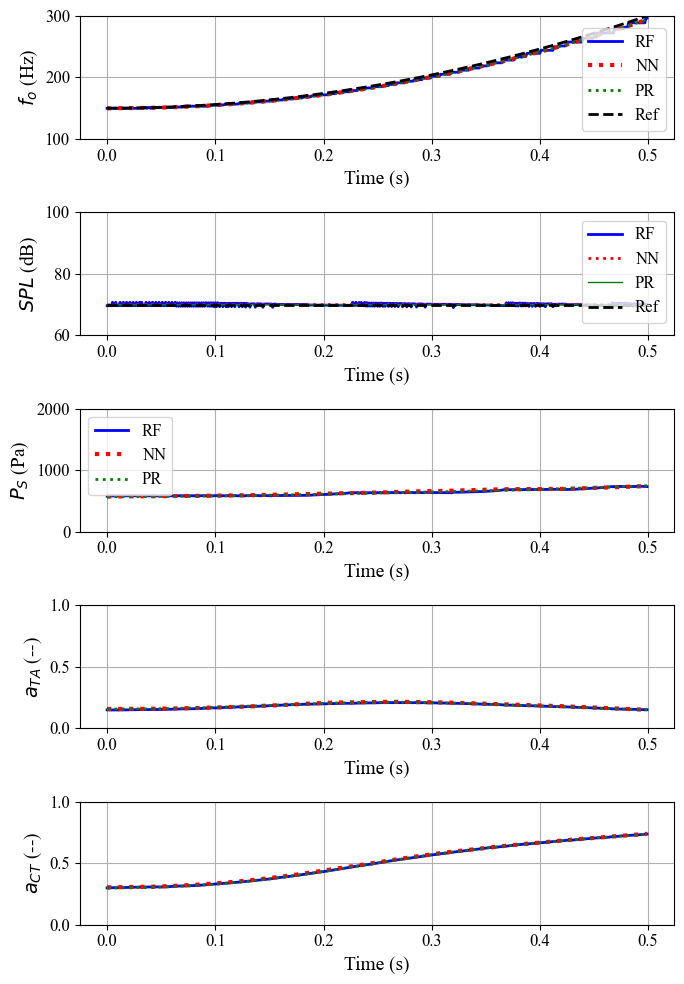

In [6]:
ges = 'fo'
# Plot resultados de las entradas
plt.figure(figsize=(7, 10))
plt.subplot(5, 1, 1)
plt.plot(t, outputHistory_RF[:, 0], 'b', linewidth=2)
plt.plot(t, outputHistory_NN[:, 0], 'r:', linewidth=3)
plt.plot(t, outputHistory_PR[:, 0], 'g:', linewidth=2)
plt.plot(t, stepRef[:, 0], 'k--', linewidth=2)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('$f_o$ (Hz)', fontsize=14)
plt.ylim([100, 300])
plt.legend(['RF', 'NN', 'PR', 'Ref'])
plt.grid(True)

plt.subplot(5, 1, 2)
plt.plot(t, outputHistory_RF[:, 1], 'b', linewidth=2)
plt.plot(t, outputHistory_NN[:, 1], 'r:', linewidth=2)
plt.plot(t, outputHistory_PR[:, 1], 'g', linewidth=1)
plt.plot(t, stepRef[:, 1], 'k--', linewidth=2)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('$SPL$ (dB)', fontsize=14)
plt.ylim([60, 100])
plt.legend(['RF', 'NN', 'PR', 'Ref'])
plt.grid(True)

plt.subplot(5, 1, 3)
plt.plot(t, inputHistory_RF[:, 2], 'b', linewidth=2)
plt.plot(t, inputHistory_NN[:, 2], 'r:', linewidth=3)
plt.plot(t, inputHistory_PR[:, 2], 'g:', linewidth=2)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('$P_S$ (Pa)', fontsize=14)
plt.ylim([0, 2000])
plt.legend(['RF', 'NN', 'PR'])
plt.grid(True)

plt.subplot(5, 1, 4)
plt.plot(t, inputHistory_RF[:, 1], 'b', linewidth=2)
plt.plot(t, inputHistory_NN[:, 1], 'r:', linewidth=3)
plt.plot(t, inputHistory_PR[:, 1], 'g:', linewidth=2)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('$a_{TA}$ (--)', fontsize=14)
plt.ylim([0, 1])
plt.grid(True)

plt.subplot(5, 1, 5)
plt.plot(t, inputHistory_RF[:, 0], 'b', linewidth=2)
plt.plot(t, inputHistory_NN[:, 0], 'r:', linewidth=3)
plt.plot(t, inputHistory_PR[:, 0], 'g:', linewidth=2)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('$a_{CT}$ (--)', fontsize=14)
plt.ylim([0, 1])
plt.grid(True)

# Ajustar los subplots para evitar superposición
plt.tight_layout()

# Show the plot
output_filename = 'Figs/Glide_'+ges+'_low.svg'
plt.savefig(output_filename, format='svg')

plt.show()

## SPL glide

In [7]:
# --- Ejemplo de uso con diferentes modelos ---

# Parámetros generales
Fs = 1000
numSteps = 500
alpha = 0.1
gamma = 0.1
epsilon = 0.02

nStep = 500

dt = 1 / Fs
t = np.arange(0, nStep) * dt

# Referencia para seguir
stepRef = np.column_stack([np.full(numSteps, 200), np.linspace(65, 85, numSteps)])

#inital point
ini = [0.1,0.1,0.1]

# Realizar seguimiento con diferentes modelos
# Random Forest
inputHistory_RF, outputHistory_RF, errorHistory_RF, t_RF = realizar_seguimiento(lambda x: evalua_rf(modelRF, x), Fs, stepRef, x_scaler, start=ini)

# Red Neuronal (Keras)
inputHistory_NN, outputHistory_NN, errorHistory_NN, t_NN = realizar_seguimiento(lambda x: evalua_nn(modelNN, x), Fs, stepRef, x_scaler, start=ini)

# Polynomial Regressor (con transformación polinómica)
inputHistory_PR, outputHistory_PR, errorHistory_PR, t_PR = realizar_seguimiento(lambda x: evalua_pr(modelPR, x, poly), Fs, stepRef, x_scaler, start=ini)

Progreso: 550/550 (100.00%)

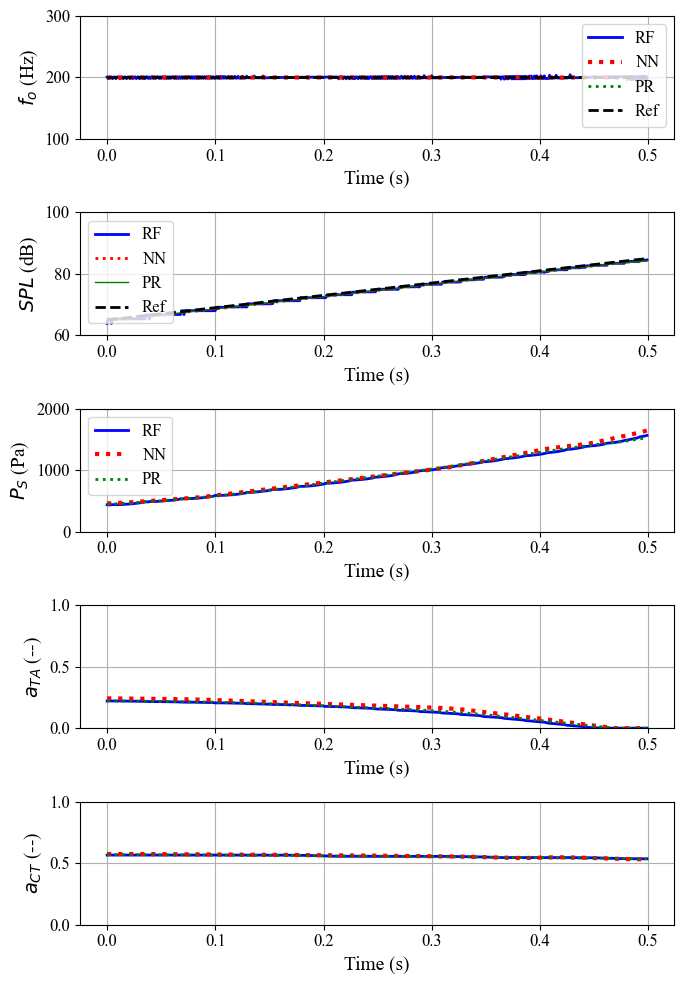

In [8]:
ges = 'spl'
# Plot resultados de las entradas
plt.figure(figsize=(7, 10))
plt.subplot(5, 1, 1)
plt.plot(t, outputHistory_RF[:, 0], 'b', linewidth=2)
plt.plot(t, outputHistory_NN[:, 0], 'r:', linewidth=3)
plt.plot(t, outputHistory_PR[:, 0], 'g:', linewidth=2)
plt.plot(t, stepRef[:, 0], 'k--', linewidth=2)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('$f_o$ (Hz)', fontsize=14)
plt.ylim([100, 300])
plt.legend(['RF', 'NN', 'PR', 'Ref'])
plt.grid(True)

plt.subplot(5, 1, 2)
plt.plot(t, outputHistory_RF[:, 1], 'b', linewidth=2)
plt.plot(t, outputHistory_NN[:, 1], 'r:', linewidth=2)
plt.plot(t, outputHistory_PR[:, 1], 'g', linewidth=1)
plt.plot(t, stepRef[:, 1], 'k--', linewidth=2)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('$SPL$ (dB)', fontsize=14)
plt.ylim([60, 100])
plt.legend(['RF', 'NN', 'PR', 'Ref'])
plt.grid(True)

plt.subplot(5, 1, 3)
plt.plot(t, inputHistory_RF[:, 2], 'b', linewidth=2)
plt.plot(t, inputHistory_NN[:, 2], 'r:', linewidth=3)
plt.plot(t, inputHistory_PR[:, 2], 'g:', linewidth=2)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('$P_S$ (Pa)', fontsize=14)
plt.ylim([0, 2000])
plt.legend(['RF', 'NN', 'PR'])
plt.grid(True)

plt.subplot(5, 1, 4)
plt.plot(t, inputHistory_RF[:, 1], 'b', linewidth=2)
plt.plot(t, inputHistory_NN[:, 1], 'r:', linewidth=3)
plt.plot(t, inputHistory_PR[:, 1], 'g:', linewidth=2)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('$a_{TA}$ (--)', fontsize=14)
plt.ylim([0, 1])
plt.grid(True)

plt.subplot(5, 1, 5)
plt.plot(t, inputHistory_RF[:, 0], 'b', linewidth=2)
plt.plot(t, inputHistory_NN[:, 0], 'r:', linewidth=3)
plt.plot(t, inputHistory_PR[:, 0], 'g:', linewidth=2)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('$a_{CT}$ (--)', fontsize=14)
plt.ylim([0, 1])
plt.grid(True)

# Ajustar los subplots para evitar superposición
plt.tight_layout()

# Show the plot
output_filename = 'Figs/Glide_'+ges+'_low.svg'
plt.savefig(output_filename, format='svg')

plt.show()